<a href="https://colab.research.google.com/github/rajeshsahu09/CS69002_9A_18CS60R19/blob/master/DL_Assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review Sentiment Analysis

### Import Header Files

In [0]:
import torch
import pandas as pd
import numpy as np
import io

### Load the Dataset and Visualise

In [0]:
# from google.colab import files
# uploaded = files.upload()

# import io
# df_train = pd.read_csv(io.StringIO(uploaded['Train_20K.csv'].decode('utf-8')), sep='\t')
# df_train.head()
url = "https://raw.githubusercontent.com/binny-mathew/IITKGP_CS69002_Spring_2019/master/Dataset/Train_20K.csv"
df_train = pd.read_csv(url, sep='\t')

In [0]:
# from google.colab import files
# uploaded = files.upload()

# import io
# df_val = pd.read_csv(io.StringIO(uploaded['check.csv'].decode('utf-8')), sep='\t')
# df_val.head()
url = "https://raw.githubusercontent.com/binny-mathew/IITKGP_CS69002_Spring_2019/master/Dataset/check.csv"
df_val = pd.read_csv(url, sep='\t')

In [0]:
# from google.colab import files
# uploaded = files.upload()

# import io
# df_test = pd.read_csv(io.StringIO(uploaded['Test_5K.csv'].decode('utf-8')), sep='\t')
# df_test.head()
url = "https://raw.githubusercontent.com/binny-mathew/IITKGP_CS69002_Spring_2019/master/Dataset/Test_5K.csv"
df_test = pd.read_csv(url, sep='\t')

In [5]:
print('Number of Negative movie reviews', len(df_train[df_train['label']==0]))
print('Number of Positive movie reviews', len(df_train[df_train['label']==1]))
print('Number of movie reviews', len(df_train['label']))

Number of Negative movie reviews 8994
Number of Positive movie reviews 9005
Number of movie reviews 17999


## Data pre-processing

### Get Train Data

In [6]:
train_raw_text_reviews = df_train['text'].astype(str).tolist()
len(train_raw_text_reviews), train_raw_text_reviews[-2]

(17999,
 'Anyone notice that Tommy only has 3 facial expressions.<br /><br />1. The angry eyes look he gives every enemy. 2. The holding of the hands to face, mouth agape and frightened eyes. 3. The smiling Tommy Turnbull.<br /><br />I have to say that i pretty much hate this show, i don\'t watch it but it\'s like Code Lyoko, we\'ve all watched at least one, i must say that this show is borderline racist, uninteresting and pointless.<br /><br />every episode ends with robotboy winning, except for one exception when robotboy basically let this overly geeky freakazoid fly away on a jetpack.<br /><br />The jokes are pretty crude too, i think it\'s mostly people saying the word "Suck" or farting, i think the bullies of the show are quite shocking too.<br /><br />Isn\'t there one that hides a bowling ball under his hate, and the other uses a chain, for god sake, what kind of school is he going to. Not to mention his older brother, who is borderline psychopathic and has no other character qu

In [7]:
train_text_labels = df_train['label'].astype(int)
len(train_text_labels), train_text_labels[len(train_text_labels)-2]

(17999, 0)

###Get Validation Data

In [8]:
val_raw_text_reviews = df_val['text'].astype(str).tolist()
len(val_raw_text_reviews), val_raw_text_reviews[-2]

(499,
 "This movie starts out brisk, has some slow moments in the middle, but generally moves along well, has a few very good moments, then peters out at the end of Act 3. I was able to get to see this in LA premieres 2 times (with 2 different endings). Jason Lee is a star, but he is not tomorrows leading man. He is humorous and holds his own, but he is better served as a supporting actor. Julia Stiles does 'ok' in a comedy role, new for her, but she doesn't 'steal' this movie, the way a star of her caliber should. For an actress who has so much potential(10 Things, Save the Last Dance, O), it is hard to watch her continue to do roles that are so 'average', and then not have her take the role and run away with the movie (like Daniel Day-Lewis did in 'Gangs'). Selma Blair is a good young actress as well, and does an 'ok' job. I didn't expect an academy award performance from her, and she didn't deliver one, but, her performance was adequate. Chris Koch delivers another film that is 'abo

In [9]:
val_text_labels = df_val['label'].astype(int)
len(val_text_labels), val_text_labels[len(val_text_labels)-2]

(499, 1)

###Get Test Data

In [10]:
test_raw_text_reviews = df_test['text'].astype(str).tolist()
len(test_raw_text_reviews), test_raw_text_reviews[-2]

(5000,
 'The Shining, you know what\'s weird about this movie? This is the movie that everyone, for people who claim to not like horror films, will always say that The Shining is a terrific film. This is Stanley Kubrick\'s classic vision of Stephen King\'s horror tale of madness and blood. This is just an incredible film and wither you have seen it or not, you have heard of it, know a few lines from it, and know some of the classic images. Who could forget Jack\'s "Here\'s Johnny!"? Who could forget "All Work and No Play Make Jack a Dull Boy"? Who could forget that chilling ending? This is the film that is unforgettable and honestly in my opinion is Kubrick\'s best work. I know there is a lot of argument in that department, a lot of people say it\'s 2001: A Space Odyssey or Clockwork Orange or even Dr. Strangelove, but if those film pioneered film making, then The Shining perfected it. This is the tale of isolation, madness, terrifying images, and the ultimate ghost story that will cra

In [11]:
test_text_labels = df_test['label'].astype(int)
len(test_text_labels), test_text_labels[len(val_text_labels)-2]

(5000, 1)

#### Cleaning the raw input data

In [12]:
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# Finding stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def preprocess_document(doc):
    # negative sense should not be eleminated + some short representation
    CONTRACTIONS = {"mayn't":"may not", "can't":"can not", "won't":"will not", "isn't":"is not", "amn't":"am not",\
                  "aren't":"are not", "wasn't":"was not", "weren't":"were not", "couldn't":"could not", \
                  "wouldn't":"would not", "don't":"do not", "doesn't":"does not",\
                  "i'll":"i will", "you'll":"you will", "they'll":"they will",\
                  "may've":"may have", "can've":"can have", "will've":"will have", "you've":"you have", \
                  "could've":"could have", "would've":"would have", "you've":"you have", "they":"they have",\
                  "i've":"i have", "you've":"you have", "we've":"we have", "there's":"there is", "i'm":"i am",\
                  "it's":"it is", "what's":"what is", "where's":"where is", "how's":"how is", "i'd":"i had"}
    punctuation = string.punctuation + "\n\n"
    punc_replace = ''.join([' ' for s in punctuation]) # required for replacing punctuation with null ('')
    doc_clean = doc.replace('-', ' ') # replace - with null str
    doc_clean = (doc_clean.encode('ascii', 'ignore')).decode("utf-8")
    doc_clean = doc_clean.replace('<br />', '') # replace <br /> with ''
    doc_clean = doc_clean.replace("’", "'") # replace <br /> with null str
    doc_clean = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in doc_clean.split(' ')] # replacing some common short forms
    doc_clean = " ".join(doc_clean) # list to sentence of strings
    doc_clean = re.sub(r'\W +', ' ', doc_clean) # except [a-zA-Z0-9_]
    doc_clean = re.sub(r'\d+', ' ', doc_clean) # remove numbers [0-9]
    trans_table = str.maketrans(punctuation, punc_replace); # replace punctuations with ' '
    doc_clean = ' '.join([word.translate(trans_table) for word in doc_clean.split(' ')])
    doc_clean = doc_clean.split(' ');
    doc_clean = [word for word in doc_clean if len(word) > 0];
    # removing the stopwords from a sentence
    doc_clean = [word for word in doc_clean if not word in stop_words and word != 'not' and word != 'no']
    return doc_clean;

In [14]:
train_text_reviews = [preprocess_document(review.lower()) for review in train_raw_text_reviews]
print (train_text_reviews[len(train_text_reviews)-2])
print (train_text_labels[len(train_text_labels)-2])

['anyone', 'notice', 'tommy', 'facial', 'expressions', 'angry', 'eyes', 'look', 'gives', 'every', 'enemy', 'holding', 'hands', 'face', 'mouth', 'agape', 'frightened', 'eyes', 'smiling', 'tommy', 'turnbull', 'say', 'pretty', 'much', 'hate', 'show', 'watch', 'like', 'code', 'lyoko', 'watched', 'least', 'one', 'must', 'say', 'show', 'borderline', 'racist', 'uninteresting', 'pointless', 'every', 'episode', 'ends', 'robotboy', 'winning', 'except', 'one', 'exception', 'robotboy', 'basically', 'let', 'overly', 'geeky', 'freakazoid', 'fly', 'away', 'jetpack', 'jokes', 'pretty', 'crude', 'think', 'mostly', 'people', 'saying', 'word', 'suck', 'farting', 'think', 'bullies', 'show', 'quite', 'shocking', 'one', 'hides', 'bowling', 'ball', 'hate', 'uses', 'chain', 'god', 'sake', 'kind', 'school', 'going', 'mention', 'older', 'brother', 'borderline', 'psychopathic', 'character', 'qualities', 'whole', 'show', 'feel', 'ripping', 'megas', 'xlr', 'fosters', 'like', 'could', 'say', 'trio', 'coop', 'jamie'

In [15]:
val_text_reviews = [preprocess_document(review.lower()) for review in val_raw_text_reviews]
print (val_text_reviews[len(val_text_reviews)-2])
print (val_text_labels[len(val_text_labels)-2])

['movie', 'starts', 'brisk', 'slow', 'moments', 'middle', 'generally', 'moves', 'along', 'well', 'good', 'moments', 'peters', 'end', 'act', 'able', 'get', 'see', 'la', 'premieres', 'times', 'different', 'endings', 'jason', 'lee', 'star', 'tomorrows', 'leading', 'man', 'humorous', 'holds', 'better', 'served', 'supporting', 'actor', 'julia', 'stiles', 'ok', 'comedy', 'role', 'new', 'steal', 'movie', 'way', 'star', 'caliber', 'actress', 'much', 'potential', 'things', 'save', 'last', 'dance', 'hard', 'watch', 'continue', 'roles', 'average', 'take', 'role', 'run', 'away', 'movie', 'like', 'daniel', 'day', 'lewis', 'gangs', 'selma', 'blair', 'good', 'young', 'actress', 'well', 'ok', 'job', 'expect', 'academy', 'award', 'performance', 'deliver', 'one', 'performance', 'adequate', 'chris', 'koch', 'delivers', 'another', 'film', 'average', 'perhaps', 'problem', 'lies', 'script', 'anything', 'else', 'like', 'movie', 'movie', 'walk', 'away', 'say', 'great', 'story', 'done', 'many', 'times', 'much'

In [16]:
test_text_reviews = [preprocess_document(review.lower()) for review in test_raw_text_reviews]
print (test_text_reviews[len(test_text_reviews)-2])
print (test_text_labels[len(test_text_labels)-2])

['shining', 'know', 'weird', 'movie', 'movie', 'everyone', 'people', 'claim', 'like', 'horror', 'films', 'always', 'say', 'shining', 'terrific', 'film', 'stanley', 'kubrick', 'classic', 'vision', 'stephen', 'king', 'horror', 'tale', 'madness', 'blood', 'incredible', 'film', 'wither', 'seen', 'heard', 'know', 'lines', 'know', 'classic', 'images', 'could', 'forget', 'jack', 'johnny', 'could', 'forget', 'work', 'play', 'make', 'jack', 'dull', 'boy', 'could', 'forget', 'chilling', 'ending', 'film', 'unforgettable', 'honestly', 'opinion', 'kubrick', 'best', 'work', 'know', 'lot', 'argument', 'department', 'lot', 'people', 'say', 'space', 'odyssey', 'clockwork', 'orange', 'even', 'dr', 'strangelove', 'film', 'pioneered', 'film', 'making', 'shining', 'perfected', 'tale', 'isolation', 'madness', 'terrifying', 'images', 'ultimate', 'ghost', 'story', 'crawl', 'underneath', 'skin', 'jack', 'torrance', 'jack', 'son', 'danny', 'jack', 'wife', 'wendy', 'arrive', 'overlook', 'hotel', 'closing', 'day'

In [17]:
import gc
gc.collect()

0

###Creating Tokens and Types

In [18]:
# Fetching the tokens (all words in a doc) and types(unique words in a doc) in the document
types = ()
tokens = []
for row in train_text_reviews+val_text_reviews+test_text_reviews:
    tokens += [words for words in row]
types = set(tokens)

VOCAB_SIZE, TOKEN_SIZE = len(types), len(tokens)
VOCAB_SIZE, TOKEN_SIZE

(72098, 2809504)

In [19]:
word_to_ix = {x:i for i, x in enumerate(types)}
ix_to_word = [x for i, x in enumerate(types)]

ix_to_word[word_to_ix['kick']]=='kick', word_to_ix['kick'], len(ix_to_word)

(True, 55949, 72098)

In [20]:
gc.collect()

174

## PyTorch

In [102]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable # Automatic gradients are calculated and back-propagated through the computational graph

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Model Definition for the BOWClassifier

In [0]:
class BOWClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BOWClassifier, self).__init__()
        SEED = 42
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size) # initialises weights and biases i2h
        self.h2o = nn.Linear(hidden_size, output_size) # initialises weights and biases h2o
#         self.i2o = nn.Linear(input_size, output_size) # initialises weights and biases i2o
         
    def forward(self, x):
        x = torch.relu(self.i2h(x)) # relu activation @ hidden layer
        x = torch.sigmoid(self.h2o(x)) # sigmoid activation @ output layer
        return x

### Initialise Parameter and Model

In [114]:
num_of_input = VOCAB_SIZE # Bag word restriction has to be equal to vocabulary
num_of_hidden = 50 # vary this for assignment
num_of_output = 1 # binary sentiment classes (+ve, -ve)

bow = BOWClassifier(num_of_input, num_of_hidden, num_of_output).to('cuda:0') # initialises weights and biases
bow.i2h, bow.h2o # desc network

# bow.i2o

(Linear(in_features=72098, out_features=50, bias=True),
 Linear(in_features=50, out_features=1, bias=True))

#### visualise the parameter

In [115]:
for param in bow.parameters(): # desc the parameter value
    print(param,param.size())

Parameter containing:
tensor([[ 0.0028,  0.0031, -0.0009,  ...,  0.0013,  0.0002,  0.0032],
        [-0.0035, -0.0032, -0.0017,  ...,  0.0025, -0.0011, -0.0002],
        [ 0.0010,  0.0022, -0.0014,  ...,  0.0005, -0.0004,  0.0025],
        ...,
        [ 0.0018,  0.0020,  0.0019,  ...,  0.0023, -0.0005, -0.0022],
        [-0.0004, -0.0036, -0.0005,  ...,  0.0002,  0.0009,  0.0002],
        [-0.0037,  0.0010, -0.0030,  ..., -0.0003, -0.0001, -0.0032]],
       device='cuda:0', requires_grad=True) torch.Size([50, 72098])
Parameter containing:
tensor([ 0.0011,  0.0004,  0.0031, -0.0034, -0.0035, -0.0011, -0.0032,  0.0018,
         0.0030,  0.0035,  0.0010, -0.0009, -0.0037,  0.0021,  0.0017,  0.0023,
        -0.0003,  0.0017, -0.0013,  0.0020,  0.0022, -0.0023,  0.0021,  0.0006,
         0.0027,  0.0002, -0.0031, -0.0016,  0.0030,  0.0012, -0.0007, -0.0016,
         0.0007,  0.0009,  0.0024,  0.0037,  0.0026,  0.0007,  0.0032, -0.0031,
        -0.0023, -0.0017, -0.0031, -0.0026,  0.0031, -

## Generate the BOW Vectors

In [0]:
def make_bow_vector(sentence, word_to_ix):
    # create a vector of zeros of vocab size = len(word_to_idx)
    vec = torch.zeros(len(word_to_ix)).to('cuda:0') #, device=device) # make 1D vector of len = vocab size
    for word in sentence:
        if word not in word_to_ix:            
#             raise ValueError('Word',word,' not present in the dictionary. Sorry!')
            pass
        else:
            vec[word_to_ix[word]]+=1 # count the number of occurance of same word in a sentences
            
    return vec.view(1, -1)

## Define Loss function

In [0]:
# define a loss function and an optimizer
loss_function = nn.BCELoss()
opt = torch.optim.SGD(bow.parameters(), lr = 0.1)#, momentum=0.9)

In [118]:
gc.collect()

584

## Train the model

In [119]:
# store the bag of word vectors for each sentences
train_data = [Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') for instance in train_text_reviews]
num_train_data = len(train_text_reviews)


val_data = [Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') for instance in val_text_reviews]
num_val_data = len(val_text_reviews)

num_train_data, num_val_data

(17999, 499)

In [120]:
type(train_data[0])

torch.Tensor

In [0]:
def evaluate_validation_accuracy(data, net):
    sum_loss = 0
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for i, instance in enumerate(data):
        label = val_text_labels[i] # get the label of the corresponding instace
        label = Variable(torch.FloatTensor([label])).resize_((1,1)).to('cuda:0') # wraps a tensor for label
        
#         vec = Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') # wrap to tensor of torch type for instance
        
#         prob = net.forward(vec) # forward pass

        prob = net.forward(instance)
    
        _class = 1 if prob.item() > 0.5 else 0 # sigmoid activated
        
        loss = loss_function(prob, label) # compute the loss
        
        sum_loss += float(loss.item())
        
        if(int(label) == _class and _class == 1):
            true_positive += 1
            
        if(int(label) == _class and _class == 0):
            true_negative += 1
        
        if(_class == 1 and int(label) == 0):
            false_positive += 1
            
        if(_class == 0 and int(label) == 1):
            false_negative += 1
    print (true_positive, true_negative, false_positive, false_negative)            
    precision = float(true_positive) / (true_positive + false_positive)
    recall = float(true_positive) / (true_positive + false_negative)
    f_score = float(2)*true_positive / (2*true_positive + false_positive + false_negative)
    
    return float(sum_loss)/len(data), float(100)*(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative), precision, recall, f_score

In [123]:
import time
# the training loop
epochs = 100
total_time = 0.0
train_epoch_history = []
train_loss_history = []
val_loss_history = []

for e in range(epochs):
    tic = time.time() # start the timer
    correct = 0
    cumulative_loss = 0
    incorrect = 0
    
    for i, instance in enumerate(train_data): # train_text_reviews 
        # get the training data
        label = train_text_labels[i] # get the label of the corresponding instace
        label = Variable(torch.FloatTensor([label])).resize_((1,1)).to('cuda:0') # wraps a tensor for label
        
        bow.zero_grad() # reset the gradient for each instance
        
#         bow_vec = Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') # vector repesentation of input sentence
        
#         pred = bow.forward(bow_vec) # forward pass ==> computes predictied values (1 or 0)
        pred = bow.forward(instance)
    
        loss = loss_function(pred, label) # compute the loss
        loss.backward() # backprop the loss
        opt.step() # performs parameter updation based on the current gradient
        
        cumulative_loss += float(loss.item()) # accumulate the loss over whole training sample
        
        pred_class = 1 if pred.item() > 0.5 else 0 # as sigmoid activated
        if(int(label) == pred_class): # counting correct prediction in each epoch
            correct += 1
        
    train_epoch_history.append(e+1)
    train_loss_history.append(float(cumulative_loss)/num_train_data)
    
    val_loss, val_accuracy, p, r, f = evaluate_validation_accuracy(val_data, bow) # test val-data-set on currently trained model
    val_loss_history.append(val_loss/num_val_data)
    
    toc = time.time() # final time
    total_time += (toc-tic)
    
    print("Epoch {}/{}\n[On Training] ==> Time: {:.2f}s, Train Loss: {:.9f}, Train Accuracy: {:.2f}%".format(e+1, epochs, (toc-tic), float(cumulative_loss)/num_train_data, correct*float(100)/num_train_data))
    print("[On Validation] ==> Precision: {:.3f}, Recall: {:.3f}, F-Score: {:.3f}, Val loss: {:.9f}, Val Accuracy: {:.2f}% Total Time: {:.2f}s".format(p, r, f, val_loss, val_accuracy, total_time))

159 215 31 94
Epoch 1/100
[On Training] ==> Time: 154.68s, Train Loss: 0.500321903, Train Accuracy: 76.55%
[On Validation] ==> Precision: 0.837, Recall: 0.628, F-Score: 0.718, Val loss: 0.474622947, Val Accuracy: 74.95% Total Time: 154.68s
216 195 51 37
Epoch 2/100
[On Training] ==> Time: 156.27s, Train Loss: 0.364977566, Train Accuracy: 84.18%
[On Validation] ==> Precision: 0.809, Recall: 0.854, F-Score: 0.831, Val loss: 0.452338686, Val Accuracy: 82.36% Total Time: 310.95s


KeyboardInterrupt: ignored

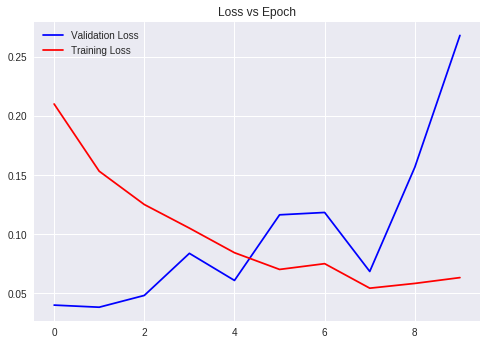

In [77]:
import matplotlib.pyplot as plt
plt.figure("Image")
plt.title("Loss vs Epoch")
val_loss_history =  [float(i)/sum(val_loss_history) for i in val_loss_history] # normalised between 0-1
train_loss_history =  [float(i)/sum(train_loss_history) for i in train_loss_history] # normalised between 0-1
plt.plot(val_loss_history, c="blue", label="Validation Loss")
plt.plot(train_loss_history, c="red", label = "Training Loss")
plt.legend()

In [0]:
print('--- AFTER TRAINING ---')
correct = 0
data = []
data = [make_bow_vector(instance, word_to_ix) for instance in test_text_reviews]
tic = time.time()
for i, instance in enumerate(data):
    label = test_text_labels[i]
    bow_vec = Variable(instance)
    logprobs = bow.forward(bow_vec)
#     print(logprobs)
    pred_class = np.argmax(logprobs.data.numpy())
    
#     print('prediction: {}'.format(pred_class))
#     print('actual: {}'.format(label))
    if(int(label) == pred_class):
        correct += 1
toc = time.time()
print("Test Accuracy: {:.2f}%".format(correct*100/len(data)))

--- AFTER TRAINING ---
Test Accuracy: 87.140%


In [0]:
torch.save(bow,'model.json')

from google.colab import files
files.download("model.json")

In [0]:
from google.colab import files
temp_test = files.upload()

In [0]:
torch.load(io.BytesIO(temp_test['model.json']))